In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
import gym
from collections import deque
import torch.nn.functional as F
import cv2
from tqdm.auto import tqdm
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [2]:
# Define the Q-Network
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims = (16,8), activation =nn.ReLU):
        super(DQN,self).__init__()

        self.input_layer = nn.Linear(input_dim,hidden_dims[0])

        self.hidden_layer = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            self.hidden_layer.append(nn.Linear(hidden_dims[i],hidden_dims[i+1]))
            self.hidden_layer.append(activation())

        self.hidden_layer = nn.Sequential(*self.hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

    def forward(self, state):
        x= state
        x = self.input_layer(x)
        x = self.hidden_layer(x)
        x= self.output_layer(x)
        return x

In [3]:
# Define DQN Agent with Experience Replay Buffer
class DQNAgent:
    def __init__(self, state_dim, action_dim, lr, gamma, epsilon, epsilon_decay, buffer_size):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.memory = deque(maxlen=buffer_size)
        self.model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.eval = False
        
    def act(self, state):
        if np.random.rand() <= self.epsilon and not self.eval:
            if self.epsilon>0.2:
                if state[1]< - 0.001:
                    return 0
                elif state[1]>0.001:
                    return 2
                else:
                    return 1
            else:
                return np.random.choice(self.action_dim)
        q_values = self.model(torch.tensor(state, dtype=torch.float32))
        return torch.argmax(q_values).item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * torch.max(self.model(torch.tensor(next_state, dtype=torch.float32))).item()
            target_f = self.model(torch.tensor(state, dtype=torch.float32)).detach().numpy()
            target_f[action] = target
            self.optimizer.zero_grad()
            loss = nn.MSELoss()(torch.tensor(target_f), self.model(torch.tensor(state, dtype=torch.float32)))
            loss.backward()
            self.optimizer.step()
        if self.epsilon > 0.01:
            self.epsilon *= self.epsilon_decay

In [4]:
# Initialize environment and agent with Experience Replay Buffer
env = gym.make('MountainCar-v0',render_mode="rgb_array",max_episode_steps=500)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQNAgent(state_dim, action_dim, lr=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.9995, buffer_size=10000)

# Train the DQN agent with Experience Replay Buffer
batch_size = 32
num_episodes = 500
rewards = []
for episode in tqdm(range(num_episodes)):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        agent.replay(batch_size)

    if total_reward <-400 and agent.epsilon<0.3:
        agent.epsilon = 0.3
        
    rewards.append(total_reward)
    print(f"Episode: {episode + 1}, Total Reward: {total_reward}, epsilone: {agent.epsilon}")

c:\Users\Home\anaconda3\envs\ai_pytorch\lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\Home\anaconda3\envs\ai_pytorch\lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


  0%|          | 0/500 [00:00<?, ?it/s]

c:\Users\Home\anaconda3\envs\ai_pytorch\lib\site-packages\gym\utils\passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode: 1, Total Reward: -94.0, epsilone: 0.9689833231354715
Episode: 2, Total Reward: -93.0, epsilone: 0.9249463838986807
Episode: 3, Total Reward: -96.0, epsilone: 0.8815870670930053
Episode: 4, Total Reward: -176.0, epsilone: 0.8073051786371559
Episode: 5, Total Reward: -163.0, epsilone: 0.7441044236465144
Episode: 6, Total Reward: -159.0, epsilone: 0.6872248269575028
Episode: 7, Total Reward: -121.0, epsilone: 0.6468706602745469
Episode: 8, Total Reward: -229.0, epsilone: 0.5768704587855094
Episode: 9, Total Reward: -214.0, epsilone: 0.5183190473649834
Episode: 10, Total Reward: -167.0, epsilone: 0.47678711536910373
Episode: 11, Total Reward: -180.0, epsilone: 0.43574080592355235
Episode: 12, Total Reward: -195.0, epsilone: 0.3952518677702707
Episode: 13, Total Reward: -199.0, epsilone: 0.35780863999054874
Episode: 14, Total Reward: -220.0, epsilone: 0.32052837601666256
Episode: 15, Total Reward: -290.0, epsilone: 0.2772541368328408
Episode: 16, Total Reward: -238.0, epsilone: 0.2

Text(0, 0.5, 'Rewards')

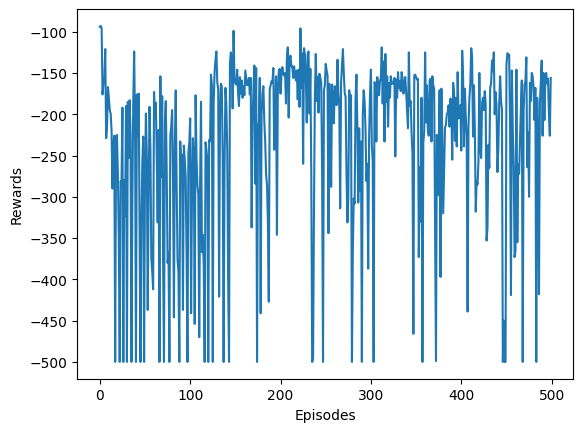

In [5]:
plt.plot(rewards)
plt.xlabel("Episodes")
plt.ylabel("Rewards")

In [6]:
import cv2

def create_video(source, fps=60, output_name='output'):
    out = cv2.VideoWriter(output_name + '.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (source[0].shape[1], source[0].shape[0]))
    for i in range(len(source)):
        out.write(source[i])
    out.release()

In [13]:
import gym
import numpy as np
from gym.wrappers import RecordVideo

agent.eval= True
# Wrap the environment for recording
# env = RecordVideo(env, video_folder="videos", episode_trigger=lambda e: True)
history = []
# Evaluate the trained agent and record video
total_rewards = []
num_episodes_eval = 200
for episode in range(num_episodes_eval):
    frames = []
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        env.render()  # Ensure rendering is active
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        state = next_state
        total_reward += reward
        frames.append(env.render(mode="rgb_array"))
        history.append({'state':state,'action':action})
    total_rewards.append(total_reward)

env.close()
print(f"Average Total Reward (Evaluation): {np.mean(total_rewards)}")




c:\Users\Home\anaconda3\envs\ai_pytorch\lib\site-packages\gym\core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Average Total Reward (Evaluation): -345.555


In [8]:
create_video(np.array(frames).reshape(-1,400,600,3), 60, 'weak RL')


In [9]:
torch.save(agent.model, 'model.pth')

In [14]:
import pandas as pd
df = pd.DataFrame(history)
df['Position'] = 0
df['Velocity'] = 0
for i in range(len(df)):
  pos,vel = df['state'].iloc[i]
  df['Position'].iloc[i] = pos
  df['Velocity'].iloc[i] = vel

df.rename(columns={'action': 'action2'}, inplace=True)
df['action'] = df['action2']
df = df.drop(columns=['state','action2'])
df.to_csv('weak_data.csv')
df

C:\Users\Home\AppData\Local\Temp\ipykernel_19048\372672881.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Position'].iloc[i] = pos
C:\Users\Home\AppData\Local\Temp\ipykernel_19048\372672881.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.5770789384841919' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df['Position'].iloc[i] = pos
C:\Users\Home\AppData\Local\Temp\ipykernel_19048\372672881.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Velocity'].iloc[i] = vel
C:\Users\Home\AppData\Lo

,Position,Velocity,action
0,-0.577079,0.000402,1
1,-0.576277,0.000802,1
2,-0.575082,0.001195,1
3,-0.573502,0.001580,1
4,-0.571550,0.001953,1
...,...,...,...
69106,0.346921,0.039250,2
69107,0.385907,0.038986,2
69108,0.424890,0.038982,2
69109,0.464143,0.039253,2


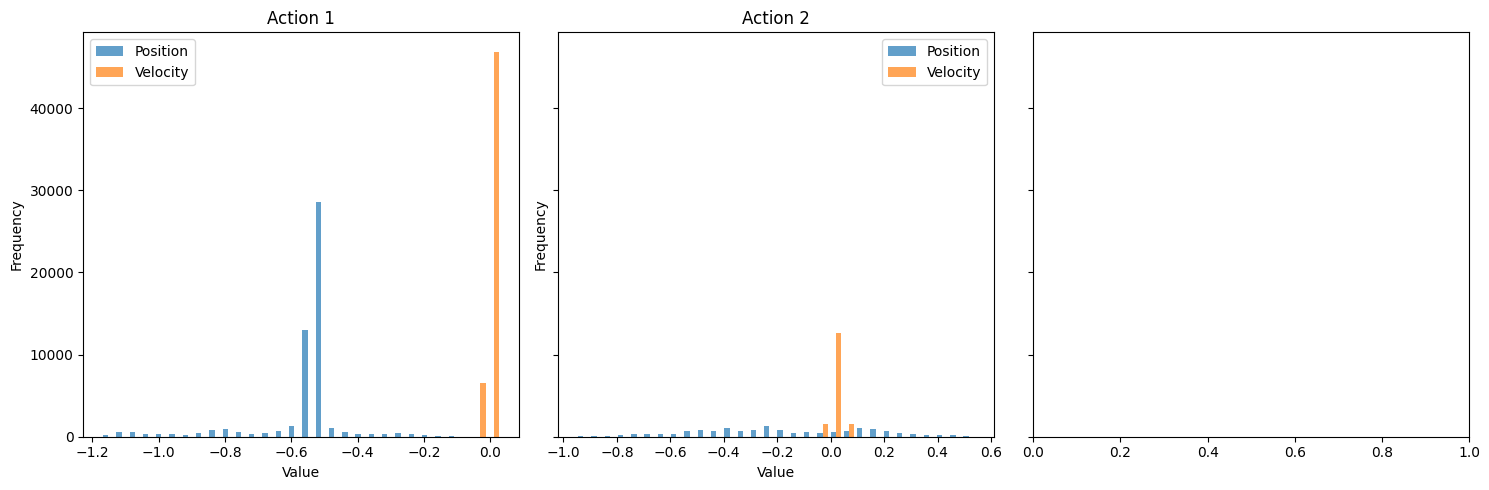

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
# Ensure 'action' is categorical
df['action'] = df['action'].astype(int)

# Unique action values
actions = df['action'].unique()

# Create histograms
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for i, action in enumerate(actions):
    subset = df[df['action'] == action]
    axes[i].hist(subset[['Position', 'Velocity']], bins=30, label=['Position', 'Velocity'], alpha=0.7)
    axes[i].set_title(f'Action {action}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
    axes[i].legend()

plt.tight_layout()
plt.show()


Action 1 - Position: mean (center) = -0.56, std (spread) = 0.14
Action 1 - Velocity: mean (center) = -0.00, std (spread) = 0.01
Action 2 - Position: mean (center) = -0.16, std (spread) = 0.32
Action 2 - Velocity: mean (center) = 0.02, std (spread) = 0.02


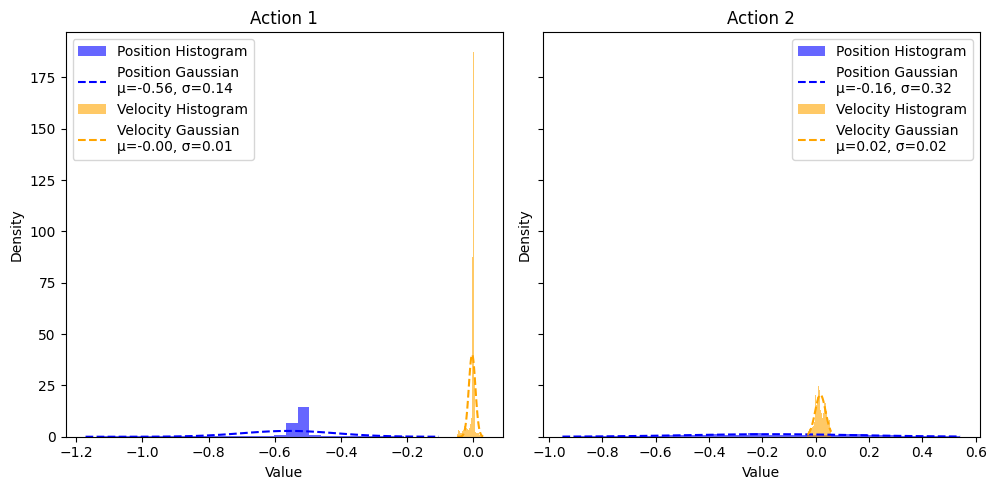

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import norm

# Sample data frame example:
# df = pd.DataFrame({
#     'action': np.random.choice([0, 1, 2], size=300),
#     'Position': np.random.normal(loc=0, scale=1, size=300),
#     'Velocity': np.random.normal(loc=5, scale=2, size=300)
# })

# Ensure 'action' is treated as integer
df['action'] = df['action'].astype(int)

# Unique action values
actions = sorted(df['action'].unique())

# Set up subplots for each action
fig, axes = plt.subplots(1, len(actions), figsize=(5 * len(actions), 5), sharey=True)

# Define colors for each variable
colors = {'Position': 'blue', 'Velocity': 'orange'}

for ax, action in zip(axes, actions):
    subset = df[df['action'] == action]

    # Loop over each variable and fit a Gaussian
    for col in ['Position', 'Velocity']:
        data = subset[col]

        # Plot histogram (density=True normalizes the histogram)
        counts, bins, patches = ax.hist(data, bins=30, density=True,
                                        alpha=0.6, color=colors[col],
                                        label=f'{col} Histogram')

        # Fit a Gaussian distribution to the data
        mu, sigma = norm.fit(data)
        print(f"Action {action} - {col}: mean (center) = {mu:.2f}, std (spread) = {sigma:.2f}")

        # Generate x values for the fitted curve
        x = np.linspace(bins[0], bins[-1], 100)
        p = norm.pdf(x, mu, sigma)

        # Plot the fitted Gaussian curve
        ax.plot(x, p, linestyle='--', color=colors[col],
                label=f'{col} Gaussian\nμ={mu:.2f}, σ={sigma:.2f}')

    ax.set_title(f'Action {action}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend()

plt.tight_layout()
plt.show()
